In [1]:
from fastai.vision.all import *

In [2]:
# #expected output 
#                                            filepaths Class
# 0  ../input/leukemia-classification/C-NMC_Leukemi...   all
# 1  ../input/leukemia-classification/C-NMC_Leukemi...   all
# 2  ../input/leukemia-classification/C-NMC_Leukemi...   all
# 3  ../input/leukemia-classification/C-NMC_Leukemi...   hem
# 4  ../input/leukemia-classification/C-NMC_Leukemi...   all
#                                            filepaths Class
# 0  ../input/leukemia-classification/C-NMC_Leukemi...   all
# 1  ../input/leukemia-classification/C-NMC_Leukemi...   all
# 2  ../input/leukemia-classification/C-NMC_Leukemi...   all
# 3  ../input/leukemia-classification/C-NMC_Leukemi...   hem
# 4  ../input/leukemia-classification/C-NMC_Leukemi...   all

In [3]:
set_seed(16)

In [4]:
path = Path("data_engineered")

In [5]:
path

Path('data_engineered')

In [6]:
path.ls()

(#5) [Path('data_engineered/validation_data'),Path('data_engineered/testing_data'),Path('data_engineered/train_data.csv'),Path('data_engineered/feature_engineer_fastai_readable_format_train.py'),Path('data_engineered/train')]

In [7]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [8]:
train_df = pd.read_csv(path/'train_data.csv')

In [9]:
train_df

image_id  label
0       UID_H20_2_1_hem.bmp      0
1      UID_H13_15_2_hem.bmp      0
2      UID_H40_19_6_hem.bmp      0
3      UID_H23_5_10_hem.bmp      0
4      UID_H20_31_2_hem.bmp      0
...                     ...    ...
10656   UID_51_83_2_all.bmp      1
10657    UID_44_2_3_all.bmp      1
10658    UID_46_7_3_all.bmp      1
10659    UID_46_7_2_all.bmp      1
10660  UID_51_118_9_all.bmp      1

[10661 rows x 2 columns]

<AxesSubplot:>

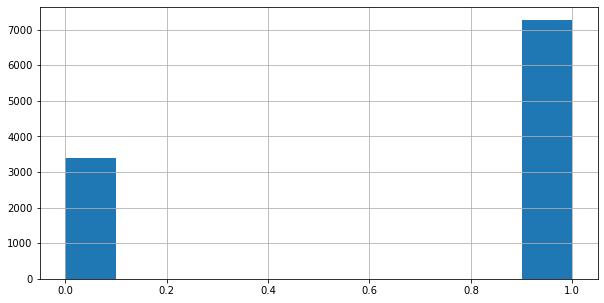

In [10]:
train_df['label'].hist(figsize = (10, 5))

In [11]:
train_df['path'] = train_df['image_id'].map(lambda x:path/'train'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(10)

label                                         path
0      1   data_engineered/train/UID_32_34_10_all.bmp
1      1     data_engineered/train/UID_43_6_2_all.bmp
2      0   data_engineered/train/UID_H23_22_3_hem.bmp
3      1    data_engineered/train/UID_48_28_8_all.bmp
4      0   data_engineered/train/UID_H10_54_1_hem.bmp
5      1    data_engineered/train/UID_47_31_3_all.bmp
6      1    data_engineered/train/UID_25_12_1_all.bmp
7      0  data_engineered/train/UID_H10_141_2_hem.bmp
8      1     data_engineered/train/UID_25_4_3_all.bmp
9      1     data_engineered/train/UID_35_9_7_all.bmp

In [12]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 
im.show()
plt.show()

450 450


In [13]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [14]:
import albumentations

In [15]:
def get_train_aug(sz): 
    return albumentations.Compose([
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.15, 
                sat_shift_limit=0.15, 
                val_shift_limit=0.15, 
                p=0.25
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.25
            ),
            albumentations.CoarseDropout(p=0.1),
            albumentations.Cutout(p=0.1)
])

def get_valid_aug(sz): 
    return albumentations.Compose([
    albumentations.CenterCrop(sz,sz, p=1.),
    albumentations.Resize(sz,sz)
], p=1.)

In [16]:
def get_dls(sz,bs):
    item_tfms = AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                                   valid_pct=0.2, #80-20 train-validation random split
                                   seed=999, #seed
                                   label_col=0, #label is in the first column of the DataFrame
                                   fn_col=1, #filename/path is in the second column of the DataFrame
                                   bs=bs, #pass in batch size
                                   item_tfms=item_tfms, #pass in item_tfms
                                   batch_tfms=batch_tfms) #pass in batch_tfms
    return dls

In [17]:
dls = get_dls(224,16)


/home/p/.is/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [20]:
vgg19_bn

<function torchvision.models.vgg.vgg19_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> torchvision.models.vgg.VGG>

In [21]:
ranger

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

In [23]:
learn = cnn_learner(dls, vgg19_bn, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(), metrics=F1Score())

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/p/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [24]:
F1Score

<function fastai.metrics.F1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None)>

In [25]:
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

In [26]:
@patch
def fine_tune_flat(self:Learner, epochs, base_lr=4e-3, freeze_epochs=1, lr_mult=100, pct_start=0.75, 
                   first_callbacks = [], second_callbacks = [], **kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.99, cbs=first_callbacks, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, cbs=second_callbacks)

SuggestedLRs(valley=0.00363078061491251)

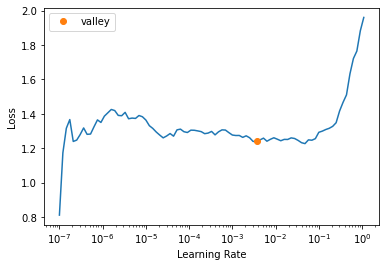

In [27]:
learn.lr_find()

In [28]:
cbs1 = [MixUp(alpha = 0.7)]
cbs2 = [MixUp(alpha = 0.3)]

In [29]:
model_name = 'vgg19'

In [30]:
learn.fine_tune_flat(5, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [31]:
learn.save(model_name + '-1')


Path('models/vgg19-1.pth')

In [32]:
learn.fine_tune_flat(5, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [33]:
learn.save(model_name + '-2')


Path('models/vgg19-2.pth')

In [34]:
learn.fine_tune_flat(7, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [35]:
learn.save(model_name + '-3')


Path('models/vgg19-3.pth')

In [36]:
learn.fine_tune_flat(10, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [37]:
learn.save(model_name + '-4')


Path('models/vgg19-4.pth')

In [38]:
cbs1 = [MixUp(alpha = 0.5)]
cbs2 = [MixUp(alpha = 0.15)]

In [39]:
learn.fine_tune_flat(10, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [40]:
learn.save(model_name + '-5')


Path('models/vgg19-5.pth')

In [41]:
learn.fine_tune_flat(10, base_lr=1e-3, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [42]:
learn.save(model_name + '-6')


Path('models/vgg19-6.pth')

In [43]:
learn.fine_tune_flat(5, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [44]:
learn.save(model_name + '-7')


Path('models/vgg19-7.pth')

In [45]:
learn.fine_tune_flat(10, base_lr=1e-5, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [46]:
learn.save(model_name + '-8')


Path('models/vgg19-8.pth')

In [47]:
path

Path('data_engineered')

In [48]:
test_df = pd.read_csv(path/'validation_data'/'C-NMC_test_prelim_phase_data_labels.csv')

In [49]:
del test_df['Patient_ID']

In [50]:
train_df.columns

Index(['label', 'path'], dtype='object')

In [51]:
test_df.columns = train_df.columns[::-1]
test_df.columns = ['old_path', 'label']
test_df.head()

old_path  label
0    1.bmp      1
1    2.bmp      1
2    3.bmp      1
3    4.bmp      0
4    5.bmp      1

In [52]:
test_df['path'] = test_df['old_path'].map(lambda x:path/'validation_data'/'C-NMC_test_prelim_phase_data'/x)
test_df = test_df.drop(columns=['old_path'])
# train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
test_df.head(10)

label                                                                 path
0      1   data_engineered/validation_data/C-NMC_test_prelim_phase_data/1.bmp
1      1   data_engineered/validation_data/C-NMC_test_prelim_phase_data/2.bmp
2      1   data_engineered/validation_data/C-NMC_test_prelim_phase_data/3.bmp
3      0   data_engineered/validation_data/C-NMC_test_prelim_phase_data/4.bmp
4      1   data_engineered/validation_data/C-NMC_test_prelim_phase_data/5.bmp
5      1   data_engineered/validation_data/C-NMC_test_prelim_phase_data/6.bmp
6      0   data_engineered/validation_data/C-NMC_test_prelim_phase_data/7.bmp
7      0   data_engineered/validation_data/C-NMC_test_prelim_phase_data/8.bmp
8      1   data_engineered/validation_data/C-NMC_test_prelim_phase_data/9.bmp
9      1  data_engineered/validation_data/C-NMC_test_prelim_phase_data/10.bmp

In [53]:
test_dl = learn.dls.test_dl(test_df)

In [54]:
test_dl

In [57]:
preds, y_preds = learn.tta(dl=test_dl)

In [58]:
preds

TensorBase([[0.1728, 0.8272],
        [0.0729, 0.9271],
        [0.0784, 0.9216],
        ...,
        [0.4962, 0.5038],
        [0.0564, 0.9436],
        [0.8925, 0.1075]])

In [59]:
y_preds = np.argmax(np.array(preds), axis=1)

In [60]:
y = np.array(test_df['label'])

In [61]:
y_preds

array([1, 1, 1, ..., 1, 1, 0])

In [62]:
y

array([1, 1, 1, ..., 0, 1, 1])

In [63]:
from sklearn.metrics import f1_score
f1_score(y, y_preds)

0.8593934619929106

In [64]:
f1_score(y, y_preds, average='weighted')

0.804506705565451

In [65]:
sum(y_preds == y)

1510

In [66]:
1564 / len(y)

0.8377075522228173

In [67]:
sum(y)

1219

In [68]:
len(y) - 1219

648

In [69]:
train_df['label'].value_counts()

1    7272
0    3389
Name: label, dtype: int64

In [70]:
sum(y_preds)

1320

In [71]:
len(y) - 1386

481

In [73]:
preds

TensorBase([[0.1728, 0.8272],
        [0.0729, 0.9271],
        [0.0784, 0.9216],
        ...,
        [0.4962, 0.5038],
        [0.0564, 0.9436],
        [0.8925, 0.1075]])

In [74]:
sys.getsizeof(preds)

72

In [75]:
len(preds)

1867

In [76]:
res_model = cnn_learner(dls, resnet50, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(), metrics=F1Score())

In [78]:
res_model.load('stage-8')

In [81]:
preds_res, y_preds_res = res_model.tta(dl=test_dl)

In [82]:
preds_res

TensorBase([[0.0460, 0.9540],
        [0.0525, 0.9475],
        [0.0523, 0.9477],
        ...,
        [0.3484, 0.6516],
        [0.2714, 0.7286],
        [0.6022, 0.3978]])

In [86]:
y_preds_res = np.argmax(np.array(preds_res), axis=1)

In [87]:
f1_score(y, y_preds_res, average='weighted')

0.8392203956948356

In [90]:
(preds.numpy() + preds_res.numpy()) / 2

array([[0.10937088, 0.8906292 ],
       [0.06271651, 0.9372835 ],
       [0.06536439, 0.93463564],
       ...,
       [0.42232952, 0.5776706 ],
       [0.16392708, 0.8360729 ],
       [0.74732924, 0.25267074]], dtype=float32)

In [91]:
hybrid_model_approximation = np.argmax(np.array((preds.numpy() + preds_res.numpy()) / 2), axis=1)

In [92]:
hybrid_model_approximation

array([1, 1, 1, ..., 1, 1, 0])

In [93]:
f1_score(y, hybrid_model_approximation, average='weighted')

0.8282063509194596

In [104]:
class HybridModel():
    def __init__(self, model_a, model_b, y):
        self.model_a = model_a
        self.model_b = model_b
        self.y = y
    
    def predict_hybrid(self, test_dl):
        preds_a, y_preds_a = self.model_a.tta(dl=test_dl)
        preds_b, y_preds_b = self.model_b.tta(dl=test_dl)
        hybrid_predictions = np.argmax(np.array((preds_a.numpy() + preds_b.numpy()) / 2), axis=1)
        return hybrid_predictions
    
    def get_f1_weighted_score(self, preds):
        return f1_score(self.y, preds, average='weighted')

In [105]:
vgg_model = learn
resnet_model = res_model
hybrid_model = HybridModel(vgg_model, resnet_model, y)

In [106]:
predictions = hybrid_model.predict_hybrid(test_dl)

In [109]:
hybrid_model.get_f1_weighted_score(predictions)

0.8231710438778169

In [110]:
7272 / 3389

2.145765712599587